In [3]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [5]:
def init_params():
    """
    初始化模型参数
    
    Returns
    ---------
        w : 根据全局参数num_inputs创建的权重数据, n * 1列向量, 服从标准正态分布
        b : 偏置项数据, 0
    """
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [6]:
def l2_penalty(w):
    """返回权重的L2范数惩罚"""
    return torch.sum(w.pow(2))/2

In [7]:
def train(lambd):
    """
    训练代码实现
    
    Parameter
    ----------
        lambd : 当lambd=0时, 禁用权重衰减。lambd越大, 权重衰减的惩罚力度越大。
    """
    w, b = init_params() # 初始化权重项、偏置项
    # 选择线性网络模型，平方损失函数
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss  # 用net,loss套了一下，如果有多种模型，可以用这个统一格式
    num_epochs, lr = 100, 0.003

    # animator画图，动态显示每5轮迭代，训练损失和测试损失
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项
            # 广播机制使L2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)  # 平方损失 + L2惩罚项
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)              # 小批量随机梯度下降
        
        if (epoch + 1) % 5 == 0:  # 每5轮迭代，画一次图
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
        
    print('w的L2范数是: ', torch.norm(w).item())


w的L2范数是:  13.49109935760498


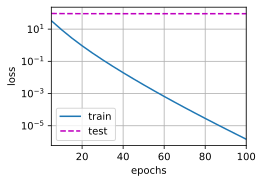

In [8]:
# 忽略正则化直接训练 ———— 训练误差一直减小，但是测试误差始终不变，说明发生了严重的过拟合
train(lambd=0)

w的L2范数是:  0.3442833721637726


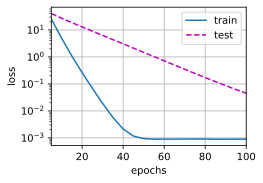

In [9]:
# 使用正则化，使得测试误差成功减小
train(lambd=3)

简洁实现

In [10]:
def train_concise(wd):
    """
    训练代码 框架式实现
    
    Parameter
    ----------
        wd : 当wd=0时, 禁用权重衰减。wd越大, 权重衰减的惩罚力度越大。
    """
    net = nn.Sequential(nn.Linear(num_inputs, 1))  # 线性网络模型
    for param in net.parameters():                 # 初始化参数
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([                    # 优化器，小批量随机梯度下降
        {"params": net[0].weight, "weight_decay": wd},
        {"params": net[0].bias}], lr=lr
    )
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch+1) % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                  d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数: ', net[0].weight.norm().item())

w的L2范数:  13.656874656677246


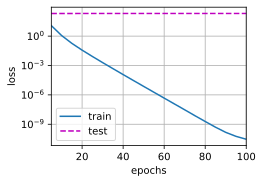

In [11]:
train_concise(0)

w的L2范数:  0.3930017650127411


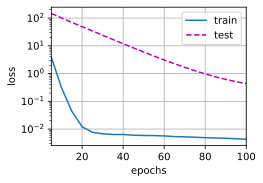

In [12]:
train_concise(3)

练习 lambd变化，训练损失和测试损失的变化探索

In [ ]:
def my_train_concise():
    """
    训练代码 框架式实现 探索lambd变化, 训练损失和测试损失的变化 并绘图
    """
    net = nn.Sequential(nn.Linear(num_inputs, 1))  # 线性网络模型
    for param in net.parameters():                 # 初始化参数
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 300, 0.003

    wd_max = 50

    animator = d2l.Animator(xlabel='wd', ylabel='loss', yscale='log',
                            xlim=[0, wd_max], legend=['train', 'test'])
    for wd in range(wd_max):
        # 偏置参数没有衰减
        trainer = torch.optim.SGD([                    # 优化器，小批量随机梯度下降
            {"params": net[0].weight, "weight_decay": wd},
            {"params": net[0].bias}], lr=lr
        )

        for epoch in range(num_epochs):
            for X, y in train_iter:
                trainer.zero_grad()
                l = loss(net(X), y)
                l.mean().backward()
                trainer.step()
        # if wd % 5 == 0:
        animator.add(wd, (d2l.evaluate_loss(net, train_iter, loss),
                                d2l.evaluate_loss(net, test_iter, loss)))

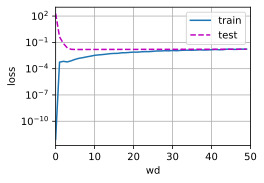

In [25]:
my_train_concise()